In [1]:
import argparse
import h5py
import numpy as np
import os
import pickle
import shutil
import yaml
import json
import click
import re
from IPython.display import Image, display
from pprint import pprint
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torch import Tensor
import vqa.lib.engine as engine
import vqa.lib.utils as utils
import vqa.lib.logger as logger
import vqa.lib.criterions as criterions
import vqa.datasets as datasets
import vqa.models as models

In [2]:
with open('options/cx/counterexamples_default.yaml', 'r') as handle:
    options = yaml.load(handle)
options['vgenome'] = None

# Load trainset

In [4]:
trainset = datasets.factory_VQA(options['vqa']['trainsplit'],
                                options['vqa'],
                                options['coco'],
                                options['vgenome'])
trainset[0].keys()

dict_keys(['visual', 'image_name', 'question_id', 'question', 'answer'])

In [5]:
train_loader = trainset.data_loader(batch_size=options['optim']['batch_size'],
                                    num_workers=1,
                                    shuffle=True)

In [6]:
for i, sample in enumerate(train_loader):
    print(sample.keys())
    break

dict_keys(['visual', 'image_name', 'question_id', 'question', 'answer'])


In [7]:
train_examples_list = pickle.load(open('data/vqa2/processed/nans,2000_maxlength,26_minwcount,0_nlp,mcb_pad,right_trainsplit,train/trainset.pickle', 'rb'))
qid_to_example = {ex['question_id']: ex for ex in train_examples_list}

In [48]:
# http://visualqa.org/data/mscoco/vqa/v2_Complementary_Pairs_Train_mscoco.zip
comp_pairs = json.load(open("data/vqa2/raw/annotations/v2_mscoco_train2014_complementary_pairs.json", "r"))

comp_q = {}
for q1, q2 in comp_pairs:
    comp_q[q1] = q2
    comp_q[q2] = q1
    
len(comp_q)

395850

# Visualize training example

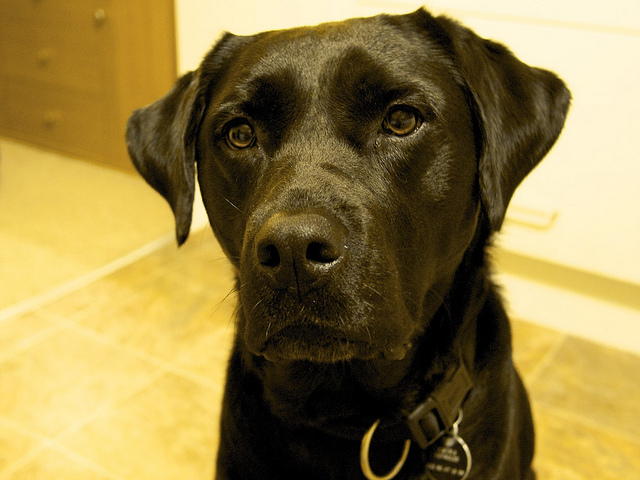

Q1: Is the dog waiting for a treat?
A1: yes



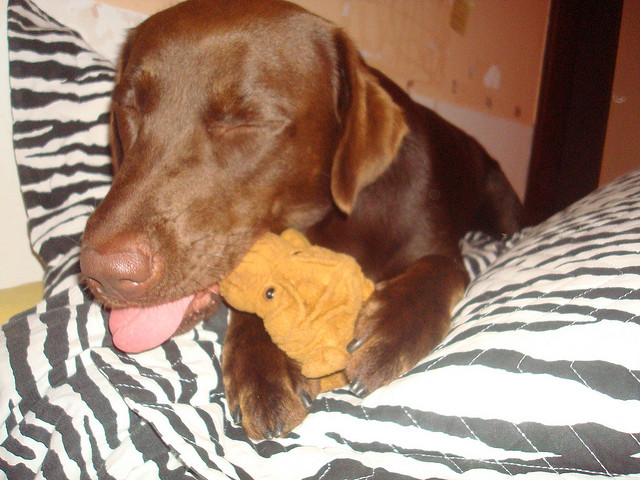

Q2: Is the dog waiting for a treat?
A2: no



In [46]:
qid = int(sample['question_id'][0])

ex1 = qid_to_example[qid]
ex2 = qid_to_example[comp_q[qid]]

display(Image(filename=os.path.join('data/coco/raw/train2014', ex1['image_name'])))
print("Q1: {}\nA1: {}\n".format(ex1['question'], ex1['answer']))

display(Image(filename=os.path.join('data/coco/raw/train2014', ex2['image_name'])))
print("Q2: {}\nA2: {}\n".format(ex2['question'], ex2['answer']))

# Load KNNs data

In [13]:
# http://visualqa.org/data/mscoco/vqa/mscoco_train2014_nn_images.json
"""
The data is in dictionary format where each key is a COCO image id and each value is a list of 24 COCO image ids 
which are 24 nearest neighbor images of the key image id sorted in increasing distance, i.e., the first image in 
the list is the 1st nearest neighbor image and the last image in the list is 24th nearest neighbor image.
"""

knns = json.load(open("data/coco/knn/mscoco_train2014_nn_images.json", "r"))
knns = {int(k):v for k,v in knns.items()}

In [14]:
def coco_name_to_num(name):
    assert(name[-4:] == '.jpg')
    assert(name[-17] == '_')
    return int(name[-16:-4])

def coco_num_to_name(num, split='train'):
    if len(str(num)) > 12:
        raise ValueError
    if split == 'train':
        return 'COCO_train2014_{}.jpg'.format(str(num).zfill(12))
    elif split == 'val':
        return 'COCO_val2014_{}.jpg'.format(str(num).zfill(12))
    else:
        raise ValueError('split must be train or val; got {}'.format(split))
    
print(coco_name_to_num('COCO_train2014_000000452014.jpg'))
print(coco_num_to_name(452014))
print(coco_num_to_name(452014, 'val'))

452014
COCO_train2014_000000452014.jpg
COCO_val2014_000000452014.jpg


# Filter down examples

In [19]:
# Get all unique q_ids in the complimentary pairs data
q_ids_alpha = []
for q1, q2 in comp_pairs:
    q_ids_alpha.append(q1)
    q_ids_alpha.append(q2)
q_ids_alpha_set = set(q_ids_alpha)

In [20]:
# Get all unique q_ids in the VQA2 training data
q_id_to_example = {ex['question_id']: ex for ex in train_examples_list}
q_ids_beta_set = set(q_id_to_example.keys())

In [60]:
# Approx 2.21% of the training example q_ids are not present in the complimentary pairs data
print(1 - len(q_ids_alpha_set) / len(q_ids_beta_set))

0.022116930951598723


In [23]:
# Additionally, the alpha and beta sets are only partially overlapping
intersection = q_ids_alpha_set.intersection(q_ids_beta_set)
print(len(intersection), len(q_ids_beta_set - q_ids_alpha_set), len(q_ids_alpha_set - q_ids_beta_set))

361722 43081 34128


In [71]:
train_examples_filtered = []

for ex in train_examples_list:
    
    q1 = ex['question_id']
    i1 = coco_name_to_num(ex['image_name'])
    
    # Ensure q1 has a compliment
    if q1 in intersection:
        q2 = comp_q[q1]
        
        # Ensure q2 has a compliment and is in the training data
        if q2 in intersection:
            
            ex2 = qid_to_example[q2]
            i2 = coco_name_to_num(ex2['image_name'])
            
            # Ensure i2 is in i1's KNNs
            if i2 in knns[i1]:
                
                ex['comp'] = ex2
                ex['comp']['knn_index'] = knns[i1].index(i2)
                ex['knns'] = [coco_num_to_name(i) for i in knns[i1]]
                
                train_examples_filtered.append(ex)
            
len(train_examples_filtered)

211626

In [76]:
# Sanity check: ensure all images in the filtered trainset are accounted for in the KNNs data

# All unique image ids in filtered trainset
v_nums_charlie = set([coco_name_to_num(ex['image_name']) for ex in train_examples_filtered])

# All unique image ids in KNNs data
v_nums_delta = set(knns.keys())

# Number of unique image ids
v_nums_intersection = v_nums_charlie.intersection(v_nums_delta)
print(len(v_nums_intersection))

# As expected, all images in the filtered trainset are accounted for in the KNNs data
print(len(v_nums_charlie - v_nums_delta), len(v_nums_delta - v_nums_charlie))

80492
0 2291


# Save the data

In [77]:
pickle.dump(train_examples_filtered, open( "trainset_augmented.pickle", "wb" ) )
pickle.dump(train_examples_filtered[:1000], open( "trainset_augmented_small.pickle", "wb" ) )